In [1]:
path= '../../models/'

In [2]:
model_list= ["1000","2908","5000","10000","15000"]

# Import Modules

In [3]:
pip uninstall tensorflow-metal --yes

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import pickle
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils
from tensorflow.keras.models import load_model
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import tensorflow_text as text

In [5]:
tf.device('/physical_device:CPU:0')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
import os
import sys
print(sys.path)
directory_path = os.path.abspath(os.path.join('../helper'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

translation_path=os.path.abspath(os.path.join('../../utils')) 
sys.path.append(translation_path)

print(sys.path)

['/Users/learn/Desktop/Projects/machine-translation/test/hindi_to_english', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles/lib/python', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages']
['/Users/learn/Desktop/Projects/machine-translation/test/hindi_to_english', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles/lib/python', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9', '/Users/learn/Desktop/

In [8]:
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence

# Download Sentences for Test

In [9]:
import pandas as pd
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

pairs=[] 
for translation_pair in dataset["train"]["translation"]:
  source_sentence = translation_pair["hi"]
  target_sentence = translation_pair["en"]
  pairs.append([source_sentence, target_sentence])


lines= pd.DataFrame(columns=[ "hindi","eng"], data=pairs)
lines= lines[:5]
lines.tail()

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

,hindi,eng
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


# Def. Get Summary Statistics for every model 

In [10]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath ):

################################## START  ##################################
    reconstructed_model = keras.models.load_model(model_path)
    plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
    reconstructed_model.summary()


    ## Load Dictionaries and Parameters 
    path_encoder_parameters= path_encoder_parameters
    path_encoder_dictionary= path_encoder_dictionary
    path_decoder_parameters= path_decoder_parameters
    path_decoder_dictionary= path_decoder_dictionary

    # loading
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    print(encoder_parameters)
    # encoder_dictionary
    print(decoder_parameters)
    # decoder_dictionary

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well


    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary


    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


   

    def make_inference_models():
        
            encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
            
            decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
            decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
            
            decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
            
            decoder_outputs, state_h, state_c = decoder_lstm(
                decoder_embedding , initial_state=decoder_states_inputs)
            decoder_states = [state_h, state_c]
            decoder_outputs = decoder_dense(decoder_outputs)
            decoder_model = tf.keras.models.Model(
                [decoder_inputs] + decoder_states_inputs,
                [decoder_outputs] + decoder_states)
            
            return encoder_model , decoder_model


    enc_model , dec_model = make_inference_models()


    # Test Previous Model


    encoderPath= encoderPath
    decoderPath= decoderPath

    # loading

    enc_model =  load_model(encoderPath)
    dec_model  =  load_model(decoderPath)



################################## END  ##################################

    ## Get sentences to test the model

    # lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
    # lines.reset_index( level=0 , inplace=True )
    # lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
    # lines = lines.drop( 'c' , 1 )  

    sample_sentences= lines[-10:]
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
        # print( line.split() ) 
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens

    ####### START Calculate Cosine Similarity for two sentences
    scores=[]
    for line in sample_sentences['eng']:
        translation= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        result= get_cosine_val (translation, line)
        scores.append(result)

    df["cosine_similarity"]= scores    ## Cosine score calculated

    ####### END Calculate Cosine Similarity for two sentences
    

    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=get_BLEU_score(df,sentence_bleu)
    df["bleu_score"]= scores    ## BLEU score calculated

    ## Calcualte ROUGE score
    scores= get_ROUGE_score(df, pd, tf,text)
    df["rouge_score"]= scores  ## ROUGE score calculated

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]

        

    

# Get Summary Statistics Table

In [11]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [12]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    # print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure", "average_cosine" ,"average_bleu"], data=stat)
table

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 256)      309760      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)       

2022-12-02 15:31:56.611586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


['1000', 0.0, 0.0, 0.0, 0.0, 0.0]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

['2908', 0.07714285, 0.084848486, 0.07222222, 0.08298853118196468, 0.06595057222007081]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      279552      ['input_1[0][0]']                
                                          

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['10000', 0.5208875, 0.53910255, 0.51111114, 0.1414213562373095, 0.491857782531529]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 256)      644608      ['input_1[0][0]']                
                                              

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,1000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2908,0.077143,0.084848,0.072222,0.082989,0.065951
2,5000,0.620635,0.653968,0.594444,0.100938,0.587706
3,10000,0.520887,0.539103,0.511111,0.141421,0.491858
4,15000,0.534524,0.565476,0.511111,0.023570,0.504030


In [13]:
table

,Dataset Size,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,1000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2908,0.077143,0.084848,0.072222,0.082989,0.065951
2,5000,0.620635,0.653968,0.594444,0.100938,0.587706
3,10000,0.520887,0.539103,0.511111,0.141421,0.491858
4,15000,0.534524,0.565476,0.511111,0.023570,0.504030


#Visualizations

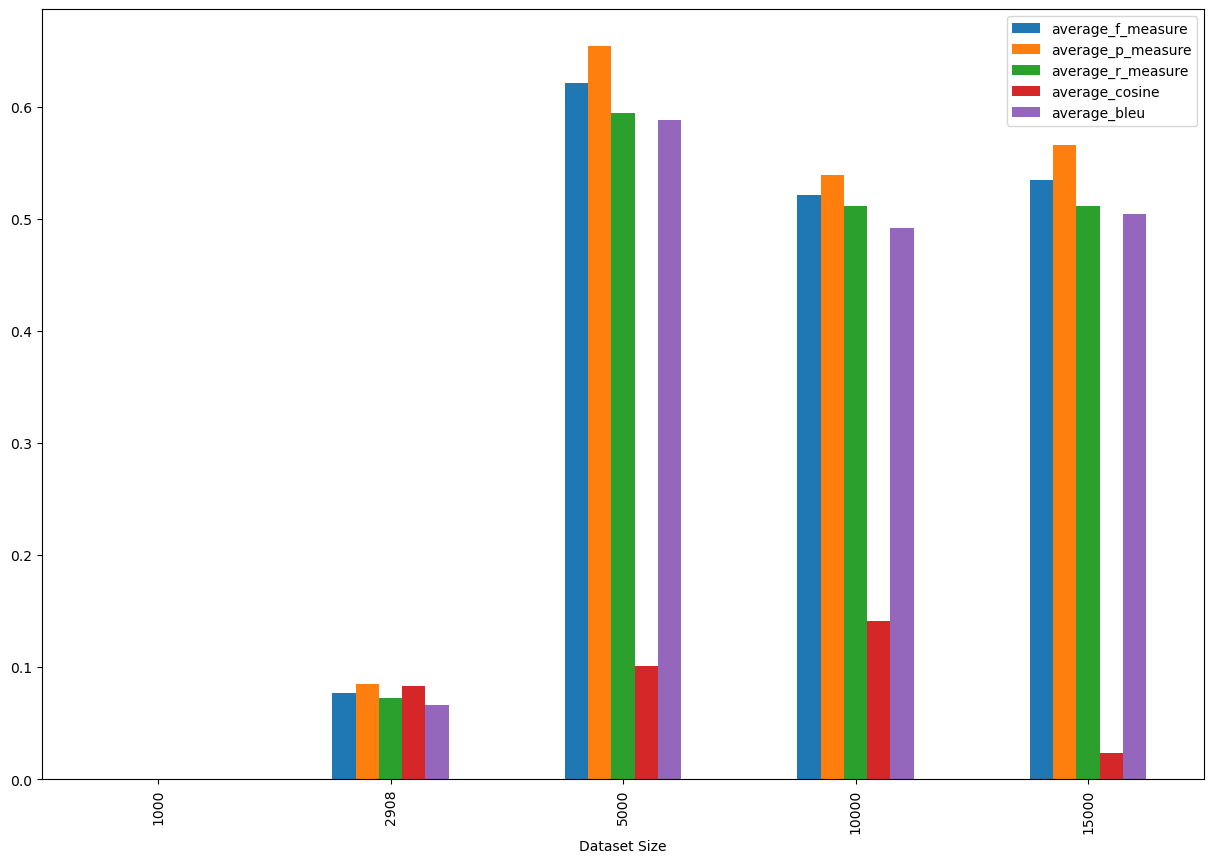

In [14]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True);

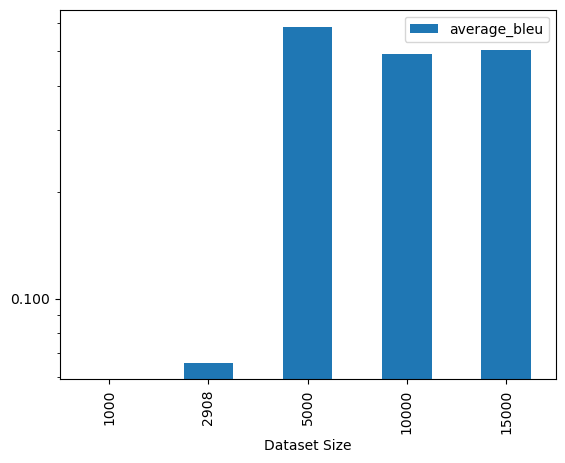

In [15]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True);